# 이미지에서 특징 감지하기

## 합성곱 신경망 만들기

In [1]:
import tensorflow as tf

### 케라스 ImageDataGenerator

In [2]:
import urllib.request
import zipfile

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

flow_from_directory(directory, target_size=(256, 256), color_mode='rgb', classes=None, class_mode='categorical', batch_size=32, shuffle=True, seed=None, save_to_dir=None, save_prefix='', save_format='png', follow_links=False, subset=None, interpolation='nearest')

In [3]:
from tensorflow.keras.optimizers import RMSprop

#### `image_dataset_from_directory` 사용하기

- 기본 파라미터
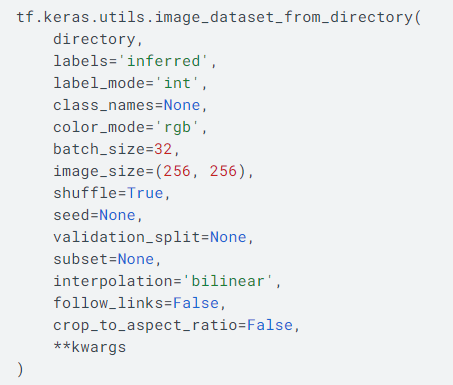

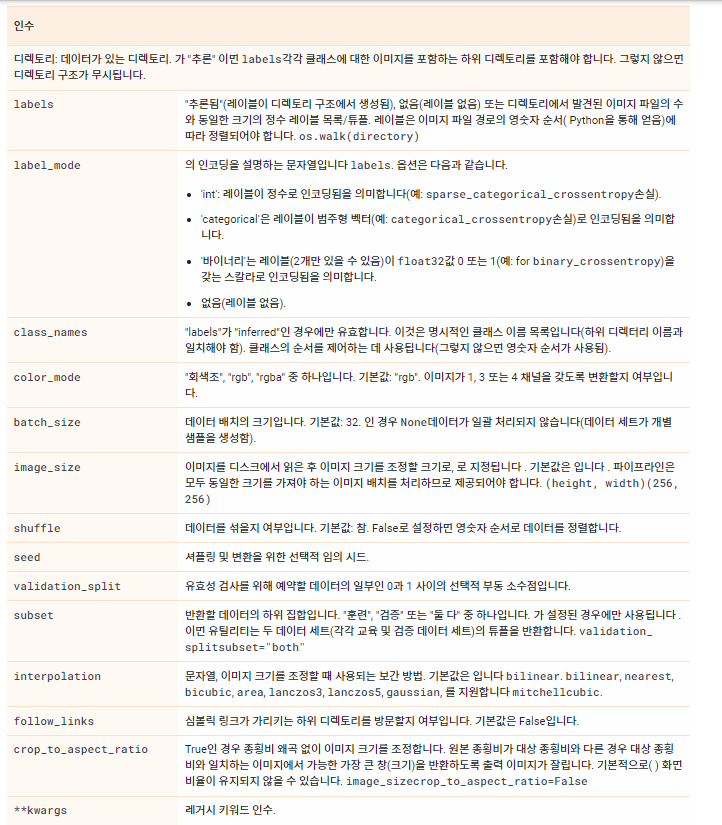

## 다중 분류

### 데이터 다운 받기

In [5]:
# !pip install wget 
#os가 리눅스일때 다운받는 패키지-파이썬 내부패키지는 윈도우에서도 적용가능

- mac : (wget 없다는 에러가 발생하면)
    - brew install wget (home brew가 있는 경우)
    - curl 설치
        - https://ftp.gnu.org/gnu/wget/ 에서 파일 다운로드 후 다운 폴더로 가서
        - $ curl -O https://ftp.gnu.org/gnu/wget/wget-1.19.5.tar.gz
        - $ tar xvf wget-1.19.5.tar.gz
        - $ cd wget-1.19.5/
        - $ ./configure --with-ssl=openssl
        - $ make
        - $ make install

In [6]:
import wget

- 윈도우 환경

In [7]:
url = "https://storage.googleapis.com/learning-datasets/rps.zip"
wget.download(url)

100% [......................................................................] 200682221 / 200682221

'rps (1).zip'

In [9]:
url = "https://storage.googleapis.com/learning-datasets/rps-test-set.zip"
wget.download(url)

100% [........................................................................] 29516758 / 29516758

'rps-test-set (2).zip'

- 리눅스 환경

In [8]:
# !wget --no-check-certificate \
#     https://storage.googleapis.com/learning-datasets/rps.zip \
#     -O ./rps.zip

In [9]:
# !wget --no-check-certificate \
#     https://storage.googleapis.com/learning-datasets/rps-test-set.zip \
#     -O ./rps-test-set.zip

- 데이터 압축 풀기

In [1]:
import zipfile
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.preprocessing import image

In [3]:
local_zip = './rps.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r') # 압축 풀고 읽기 r, 만들기는 w
zip_ref.extractall('./')
zip_ref.close()

- 학습데이터 전처리및 데이터 증강을 위한 객체 생성
    - 증강을 사용하므로 전처리객체는 학습/평가 데이터 각각 생성

In [9]:
TRAINING_DIR = "./rps/"
training_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 15,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.5,
    zoom_range = [0.8, 2.0],
    horizontal_flip = True,
    fill_mode = 'nearest'
)

- 검증데이터 준비 및 전처리

### 이미지 파일을 split 해주는 패키지
- !pip install split-folders
- !pip install split-folders[full] 
    - progress bar를 보고 싶을때

In [5]:
# !pip install split-folders[full]

In [6]:
local_zip = './rps-test-set.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./')
zip_ref.close()

# train/val/test 나누기

- ratio 파라미터에 원하는 (train, validation, test) 비율을 입력 ex) (0.8, 0.1, 0.1)
    - splitfolders.ratio("input_folder", output="output", seed=1337, ratio=(.8, .1, .1))
    
- train/val 나누기 : train을 val로 val을 test로 사용
    - test는 제외하고 train, validation만 나누고 싶다면 두 개의 인자만 입력 ex) (0.8, 0.1)

In [7]:
import splitfolders

test_set_dir = "./rps-test-set"
test_val_dir = "./rps-test-val"

splitfolders.ratio(test_set_dir, output = test_val_dir, seed = 1337, ratio = (0.8, 0.2))

Copying files: 372 files [00:03, 108.40 files/s]


In [7]:
VALIDATION_DIR = "./rps-test-val/train"
TEST_DIR = "./rps-test-val/val"

### 이미지 전처리

In [4]:
# 검증, 테스트 데이터는 증강 사용하지 않음
val_datagen = ImageDataGenerator(
    rescale = 1./255
)

In [5]:
## 이미지 증식 generator 생성
train_datagen = ImageDataGenerator()

In [10]:
# train_datagen generaotr로 train,val,test 이미지 증식
# 학습데이터만 증식해도 무방 함
train_generator = train_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size = (300, 300),
    class_mode = 'categorical'
)

validation_generator = val_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size = (300, 300),
    class_mode = 'categorical'
)

test_generator = val_datagen.flow_from_directory(
    TEST_DIR,
    target_size = (300, 300),
    class_mode = 'categorical'
)

Found 2520 images belonging to 3 classes.
Found 297 images belonging to 3 classes.
Found 75 images belonging to 3 classes.


## 모델 생성

In [14]:
# 앞에서 사용했던 기본 모델 사용
model_b = tf.keras.models.Sequential([
    # 입력 크기는 원하는 이미지(150x150, 3채널)와 맞아야 합니다.
    # 첫 번째 합성곱 층
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', 
                           input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    # 두 번째 합성곱 층
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    # 세 번째 합성곱 층
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    # 네 번째 합성곱 층
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    # 밀집 층에 전달하가 위해 펼칩니다.
    tf.keras.layers.Flatten(),
    # 512개 뉴런을 가진 은닉층
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
    # 출력층(다중분류이므로 softmax)
])

In [15]:
model_b.compile(loss='categorical_crossentropy', optimizer='rmsprop', 
              metrics=['accuracy'])

In [16]:
model_b.fit(train_generator, 
          epochs=25, 
          validation_data = validation_generator)

Epoch 1/25
14/79 [====>.........................] - ETA: 9s - loss: 207.4593 - accuracy: 0.4978

KeyboardInterrupt: 

- val_loss: 0.3668 - val_accuracy: 0.9125
    - 이전 훈련에 더 좋은 loss 점수가 보임
- chk point 및 early stopping 사용할 필요가 있어보임

In [24]:
# 테스트 data 검증
model_b.evaluate(test_generator)

3/3 [==============================] - 1s 117ms/step - loss: 2.3635 - accuracy: 0.9867


[2.3635411262512207, 0.9866666793823242]

### test data 검증결과
- [0.3739057779312134, 0.8933333158493042]
- 학습 데이터와 test 데이터가 차이가 있음(더 학습할 여지가 있음)

In [46]:
# 조기 종료 및 chk pint 코드
ck_cb = tf.keras.callbacks.ModelCheckpoint("rps-best-model.h5")
early_cb = tf.keras.callbacks.EarlyStopping(patience = 2,
                                            restore_best_weights = True)
history = model_b.fit(train_generator, epochs = 20, 
                    validation_data = validation_generator,
                    callbacks = [ck_cb, early_cb])

Epoch 1/20
79/79 [==============================] - 94s 1s/step - loss: 1.0978 - accuracy: 0.4817 - val_loss: 0.7502 - val_accuracy: 0.6397


C:\Anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/20
79/79 [==============================] - 96s 1s/step - loss: 0.5926 - accuracy: 0.7687 - val_loss: 0.2593 - val_accuracy: 0.8990
Epoch 3/20
79/79 [==============================] - 100s 1s/step - loss: 0.2959 - accuracy: 0.8933 - val_loss: 0.2635 - val_accuracy: 0.8788
Epoch 4/20
79/79 [==============================] - 101s 1s/step - loss: 0.2060 - accuracy: 0.9258 - val_loss: 0.0572 - val_accuracy: 0.9798
Epoch 5/20
79/79 [==============================] - 97s 1s/step - loss: 0.1416 - accuracy: 0.9476 - val_loss: 0.1157 - val_accuracy: 0.9630
Epoch 6/20
79/79 [==============================] - 100s 1s/step - loss: 0.1149 - accuracy: 0.9603 - val_loss: 0.0905 - val_accuracy: 0.9764


In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

#### 조기종료, 체크포인트 추가

- 예측 확인

In [36]:
import sys
sample_images = ['./image/rsp_image_{}.jpg'.format(i) for i in range(1,4)]

In [37]:
sample_images.append('./image/rsp_image_4.png')

In [38]:
sample_images

['./image/rsp_image_1.jpg',
 './image/rsp_image_2.jpg',
 './image/rsp_image_3.jpg',
 './image/rsp_image_4.png']

### np.expand_dims 함수
- numpy 패키지에서 제공하는 함수로, 배열의 차원을 확장
- 주로 딥러닝에서 다차원 배열을 다룰 때 사용되며, 특히 텐서의 차원을 조정할 때 자주 활용됨
- 문법
    - np.expand_dims(arr, axis)
        - arr: 차원을 확장할 배열
        - axis: 새로 추가될 차원의 위치. 이 값은 정수 또는 튜플 형태로 지정할 수 있음. 기본값은 0이며, 이는 첫 번째 차원(인덱스 0) 앞에 새로운 차원을 추가하겠다는 의미임

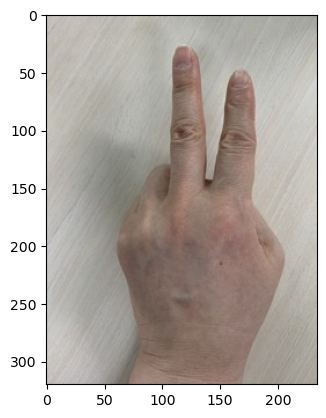

1/1 [==============================] - 0s 124ms/step
[[4.5143771e-22 1.6847054e-16 1.0000000e+00]]
./image/rsp_image_1.jpg는 가위입니다.


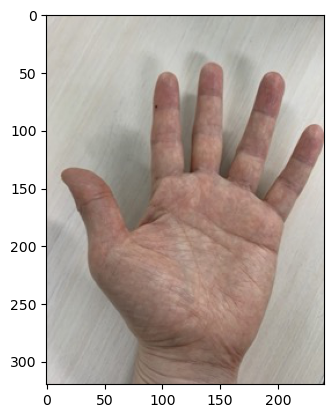

1/1 [==============================] - 0s 55ms/step
[[3.5010903e-23 6.5511625e-15 1.0000000e+00]]
./image/rsp_image_2.jpg는 가위입니다.


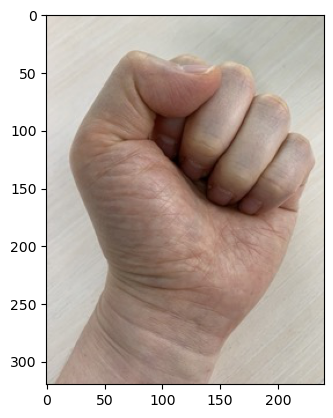

1/1 [==============================] - 0s 48ms/step
[[2.3766498e-23 8.6033527e-17 1.0000000e+00]]
./image/rsp_image_3.jpg는 가위입니다.


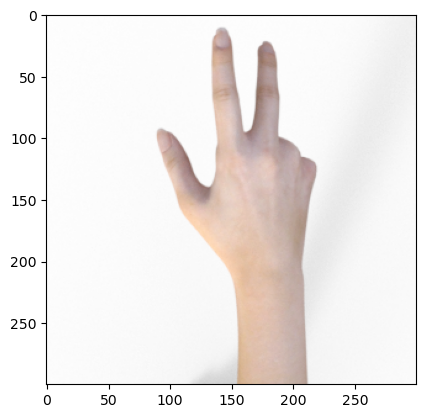

1/1 [==============================] - 0s 57ms/step
[[6.2730554e-34 3.2193305e-24 1.0000000e+00]]
./image/rsp_image_4.png는 가위입니다.


In [47]:
rsp_name = ['보', '바위', '가위']

for fn in sample_images:
    # 이미지 출력
    plt.imshow(mpimg.imread(fn))
    plt.show()
    
    # 이미지 불러오기
    img = tf.keras.utils.load_img(fn, target_size = (300, 300))
    x = tf.keras.utils.img_to_array(img)
    x = np.expand_dims(x, axis = 0)
    
    classes = model.predict(x) # 보, 바위, 가위의 각 확률값이 나옴
    print(classes)
    idx = np.argmax(classes[0])
    
    print(fn + "는 {}입니다.".format(rsp_name[idx]))

## 드롭아웃 규제
- 과대적합 방지
- 신경망층에서 dropout 추가 : drop 아웃층은 어디든 상관없음
- Improving neural networks by preventing co-adaptation of feature 논문에 따르면 dropout이 많은 모델일 수록 loss 증가를 막는 연구가 있음
    - 단 dropout은 너무 많으면 속도가 급격히 느려진다
        - 그러므로 많은 차이가 없으면 밀집신경망층 1개 정도에 추가하는 것이 일반적임

In [52]:
model_d = tf.keras.models.Sequential([
    # 입력 크기는 원하는 이미지(300x300, 3채널)와 맞아야 합니다.
    # 첫 번째 합성곱 층
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', 
                           input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    # 두 번째 합성곱 층
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    # 세 번째 합성곱 층
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    # 네 번째 합성곱 층
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    # 밀집 층에 전달하기 위해 펼칩니다.
    tf.keras.layers.Flatten(),
    # 512개 뉴런을 가진 은닉층
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),  

    tf.keras.layers.Dense(3, activation='softmax') # 출력층(다중분류이므로 softmax)
])

In [53]:
model_d.compile(loss='categorical_crossentropy',optimizer='rmsprop', 
              metrics=['accuracy'])

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('best-model.h5')
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)
history = model_d.fit(train_generator, epochs=25, verbose=0, 
                    validation_data=validation_generator,
                    callbacks=[checkpoint_cb, early_stopping_cb])

KeyboardInterrupt: 

In [41]:
model_d.evaluate(test_generator)

3/3 [==============================] - 1s 146ms/step - loss: 0.2159 - accuracy: 0.9200


[0.21590866148471832, 0.9200000166893005]

### dropout으로 단순화 결과
- 테스트 데이터의 확인은 DROPOUT 하지 않은 것보다 떨어짐

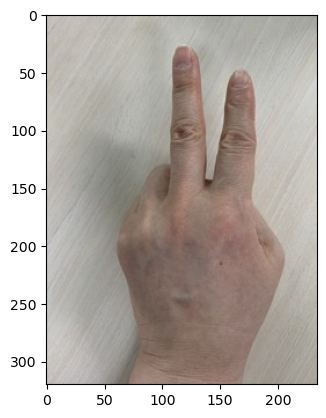

(150, 150, 3)
(1, 150, 150, 3)


InvalidArgumentError: Graph execution error:

Detected at node sequential_1/dense_2/Relu defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 736, in start

  File "C:\Anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 516, in dispatch_queue

  File "C:\Anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 505, in process_one

  File "C:\Anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 412, in dispatch_shell

  File "C:\Anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 740, in execute_request

  File "C:\Anaconda3\Lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute

  File "C:\Anaconda3\Lib\site-packages\ipykernel\zmqshell.py", line 546, in run_cell

  File "C:\Anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3024, in run_cell

  File "C:\Anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3079, in _run_cell

  File "C:\Anaconda3\Lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "C:\Anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3284, in run_cell_async

  File "C:\Anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3466, in run_ast_nodes

  File "C:\Anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code

  File "C:\Users\82105\AppData\Local\Temp\ipykernel_125648\455478281.py", line 15, in <module>

  File "C:\Anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "C:\Anaconda3\Lib\site-packages\keras\src\engine\training.py", line 2631, in predict

  File "C:\Anaconda3\Lib\site-packages\keras\src\engine\training.py", line 2416, in predict_function

  File "C:\Anaconda3\Lib\site-packages\keras\src\engine\training.py", line 2401, in step_function

  File "C:\Anaconda3\Lib\site-packages\keras\src\engine\training.py", line 2389, in run_step

  File "C:\Anaconda3\Lib\site-packages\keras\src\engine\training.py", line 2357, in predict_step

  File "C:\Anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "C:\Anaconda3\Lib\site-packages\keras\src\engine\training.py", line 589, in __call__

  File "C:\Anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "C:\Anaconda3\Lib\site-packages\keras\src\engine\base_layer.py", line 1149, in __call__

  File "C:\Anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler

  File "C:\Anaconda3\Lib\site-packages\keras\src\engine\sequential.py", line 398, in call

  File "C:\Anaconda3\Lib\site-packages\keras\src\engine\functional.py", line 515, in call

  File "C:\Anaconda3\Lib\site-packages\keras\src\engine\functional.py", line 672, in _run_internal_graph

  File "C:\Anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "C:\Anaconda3\Lib\site-packages\keras\src\engine\base_layer.py", line 1149, in __call__

  File "C:\Anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler

  File "C:\Anaconda3\Lib\site-packages\keras\src\layers\core\dense.py", line 255, in call

  File "C:\Anaconda3\Lib\site-packages\keras\src\activations.py", line 306, in relu

  File "C:\Anaconda3\Lib\site-packages\keras\src\backend.py", line 5397, in relu

Matrix size-incompatible: In[0]: [1,6272], In[1]: [32768,512]
	 [[{{node sequential_1/dense_2/Relu}}]] [Op:__inference_predict_function_29101]

In [54]:
rsp_name = ['보', '바위', '가위']

for fn in sample_images:
    # 이미지 출력
    plt.imshow(mpimg.imread(fn))
    plt.show()
    
    # 이미지 불러오기
    img = tf.keras.utils.load_img(fn, target_size=(150, 150))
    x = tf.keras.utils.img_to_array(img) # 학습시에는 generator가 실행했음
    print(x.shape)
    x = np.expand_dims(x, axis=0) # 이미지는 3차원 입력은 4차원 배열이어야 함
    print(x.shape)

    classes = model.predict(x)

    idx = np.argmax(classes[0])
    print(fn + "는 {}입니다.".format(rsp_name[idx]))

- 실제 이미지로 테스트 했을때로 성능이 떨어짐
    - dropout 규제는 효과가 없다

In [56]:
import tensorflow as tf
# import tensorflow_datasets as tfds
import tensorflow.keras as keras

import numpy as np
import matplotlib.pyplot as plt

### 모델 재구성
- 패딩을 진행하고 노드수를 줄여서 진행 
- dropout을 추가
- opt 함수 변경
    - 효과적이지못함    

In [57]:
### CNN 적용시 padding 사용하는 방법
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(32, 3, padding = 'same', activation = 'relu',
                              input_shape = (300, 300, 3)))
model.add(keras.layers.Maxpooling2D((2, 2)))

model.add(keras.layers.Conv2D(32, 3, padding = 'same', activation = 'relu',
                              input_shape = (300, 300, 3)))
model.add(keras.layers.Maxpooling2D((2, 2)))

model.add(keras.layers.Conv2D(64, 3, padding = 'same', activation = 'relu',
                              input_shape = (300, 300, 3)))
model.add(keras.layers.Maxpooling2D((2, 2)))

model.add(keras.layers.Conv2D(64, 3, padding = 'same', activation = 'relu',
                              input_shape = (300, 300, 3)))
model.add(keras.layers.Maxpooling2D((2, 2)))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(512, activation = 'relu'))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(3, activation = 'softmax'))

AttributeError: module 'keras.api._v2.keras.layers' has no attribute 'Maxpooling2D'

In [46]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])

- label이 범주형이므로 'categorical_crossentropy'
- label이 정수형(1,2,3)이면 'sparse_categorical_crossentropy

In [ ]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('best-model.h5')
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)

In [8]:
model.fit(train_generator, 
          epochs=25, 
          validation_data=validation_generator,
          callbacks = [checkpoint_cb, early_stopping_cb])

In [9]:
model.evaluate(test_generator)

In [10]:
rsp_name = ['보', '바위', '가위']

for fn in sample_images:
    # 이미지 출력
    plt.imshow(mpimg.imread(fn))
    plt.show()
    
    # 이미지 불러오기
    img = tf.keras.utils.load_img(fn, target_size=(150, 150))
    x = tf.keras.utils.img_to_array(img) # 학습시에는 generator가 실행했음
    print(x.shape)
    x = np.expand_dims(x, axis=0) # 이미지는 3차원 입력은 4차원 배열이어야 함
    print(x.shape)

    classes = model.predict(x)
    print(classes)
    idx = np.argmax(classes[0])
    print(fn + "는 {}입니다.".format(rsp_name[idx]))

## 층을 여려 경우로  구성해서 모델링을 진행하고 가장 좋은 성능평가나 혹은 테스트 결과의 모델을 사용
- 여기서 사용한 모델은 첫번째 모델이 가장 좋은 결과를 보임
    - 본인 결과로 정리
- 현재 실습은 딥러닝 돌리기에는 이미지 수가 작아보임